# Learning from experts

In [37]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt

In [102]:
# number of experts
n = 100
# number of rounds played
T = 10000

## Problem setup

We assume the existance of a set of predetermined answers: *Yes* or *No*.

In [103]:
list_of_correct_answers = random.choice([False, True], T)
probs = [random.random()**(1/2) for _ in range(n)]

Every expert gets a probability with which they give a wrong answer.

In [112]:
def get_expert_answers(n, true_answer, probs):
    """Generate expert answers based on the true answer and a given probability 
    of lying for each expert."""
    expert_answers = np.empty_like(probs, dtype=bool)
    rnd = random.random(n)
    experts_that_lie = (rnd <= probs)
    expert_answers[experts_that_lie] = np.logical_not(true_answer)
    expert_answers[~experts_that_lie] = true_answer
    
    return expert_answers

## The algorithm

If an expert $i$ is wrong its weight for the next round gets decreased according to the rule:
$$w_{t+1}(i) = w_t(i) (1-\alpha).$$

The next method implements the *randomized and the deterministic* method via the `randomized` flag.

In [113]:
def WMA(n, T, probs, list_of_correct_answers, alpha=0.1, randomized=False):
    """Run the weighted majority algorithm with `n` experts for `T` timesteps"""
    
    # initialize weights
    weights = np.ones(n)
    numof_your_mistakes = 0
    numof_expert_mistakes = np.zeros((n,T+1))
    
    # initialize regret
    regret = np.zeros(T)
    
    for t in range(T):       
        true_answer = list_of_correct_answers[t]
        expert_answers = get_expert_answers(n, true_answer, probs)
        your_answer = form_your_answer(expert_answers, weights, randomized)
          
        # check result      
        if your_answer != true_answer:
            numof_your_mistakes += 1
            
        # update weights and expert mistakes
        wrong = expert_answers != true_answer
        numof_expert_mistakes[wrong, t+1] = numof_expert_mistakes[wrong, t]+1
        numof_expert_mistakes[~wrong, t+1] = numof_expert_mistakes[~wrong, t]
        weights[expert_answers != true_answer] *= 1-alpha
        
        # store regret value at t
        regret[t] = numof_your_mistakes - min(numof_expert_mistakes[:, t+1])
                
    return numof_your_mistakes, numof_expert_mistakes, regret     

The next function is just part of WMA.

In [75]:
def form_your_answer(expert_answers, weights, randomized):
    """Return your answer in one round of the (randomized) WMA algorithm based 
    on the answers of the experts and the corresponding weights"""

    if randomized:
        # compute norm of weights
        w_norm = np.linalg.norm(weights, 1)
        # compute probabilities
        probs_ = np.zeros(len(weights))
        for i in range(0, len(weights)):
            probs_[i] = weights[i] / w_norm
        # pick the answer of a random expert
        your_answer = random.choice(expert_answers, size=1, p=probs_)
    else:          
        weight_yes = weights[expert_answers].sum()
        weight_no = len(weights) - weight_yes
        your_answer = True if weight_yes > weight_no else False
            
    return your_answer

## Experiments

In [105]:
alpha = 0.1
my_mistakes_det, expert_mistakes_det, regret = WMA(n, T, probs, list_of_correct_answers, alpha)

In [106]:
print(f'I made {my_mistakes_det} mistakes.')
print(f'Best expert had {np.min(expert_mistakes_det[:, -1])} mistakes')

I made 4973 mistakes.
Best expert had 891.0 mistakes


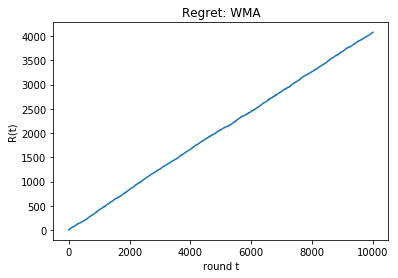

In [107]:
plt.plot(range(1, T+1), regret)
plt.title("Regret: WMA")
plt.xlabel("round t")
plt.ylabel("R(t)")
plt.show()

In [108]:
my_mistakes_rand, expert_mistakes_rand, regret_rand = WMA(n, T, probs, list_of_correct_answers, alpha, randomized=True)

In [109]:
print(f'I made {my_mistakes_rand} mistakes.')
print(f'Best expert had {np.min(expert_mistakes_rand[:, -1])} mistakes')

I made 926 mistakes.
Best expert had 875.0 mistakes


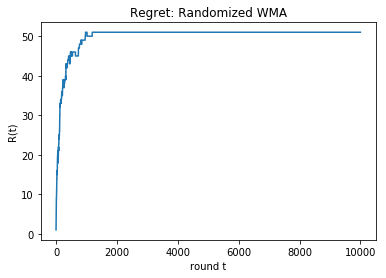

In [110]:
plt.plot(range(1, T+1), regret_rand)
plt.title("Regret: Randomized WMA")
plt.xlabel("round t")
plt.ylabel("R(t)")
plt.show()

# Tasks

TODO:
- finish the `form_your_answer` function
- plot the regret and experiment with number of rounds / experts / $\alpha$

Bonus points: If you do any of the following

- try different strategies for the experts (not just random lying)
    + you could try and manually "hardcode" an adversary that bases their strategy on your answer (always tells the truth until they have the highest weight, then they start lying)
- implement the multiplicative weights algorithm (i.e. allow for general losses, not just 0/1) and run similar experiments

In [119]:
# more experiment
def do_experiment(n, T, alpha, randomized=False):
    correct_answers = random.choice([False, True], T)
    probs = [random.random()**(1/2) for _ in range(n)]
    
    my_mistakes, expert_mistakes, regret = WMA(n, T, probs, correct_answers, alpha, randomized)
    
    print(f'I made {my_mistakes} mistakes.')
    print(f'Best expert had {np.min(expert_mistakes[:, -1])} mistakes')
    
    return my_mistakes, expert_mistakes, regret

T = 1000
print('Experiment 1')
my_mistakes1, expert_mistakes1, regret1 = do_experiment(500, 1000, 0.3)

print('Experiment 2')
my_mistakes2, expert_mistakes2, regret2 = do_experiment(10000, 1000, 0.1)

print('Experiment 3')
my_mistakes3, expert_mistakes3, regret3 = do_experiment(10, 1000, 0.2)

Experiment 1
I made 525 mistakes.
Best expert had 60.0 mistakes
Experiment 2
I made 502 mistakes.
Best expert had 14.0 mistakes
Experiment 3
I made 533 mistakes.
Best expert had 197.0 mistakes


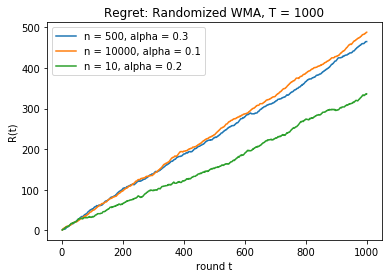

In [121]:
T = 1000
plt.plot(range(1, T+1), regret1, label = "n = 500, alpha = 0.3")
plt.plot(range(1, T+1), regret2, label = "n = 10000, alpha = 0.1")
plt.plot(range(1, T+1), regret3, label = "n = 10, alpha = 0.2")
plt.title("Regret: Randomized WMA, T = 1000")
plt.xlabel("round t")
plt.ylabel("R(t)")
plt.legend()
plt.show()